In [1]:
import requests
import json
from sklearn.cluster import KMeans
import umap
import numpy as np
import requests
import matplotlib.pyplot as plt
import pickle
from helper_funcs import cluster_names, locations, get_stats_from_scid, draw_court, get_post_processed_data

In [2]:
def get_model(before_umap_shot_chart_data, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=2000).fit(before_umap_shot_chart_data)
    return kmeans 

In [3]:
def get_plots(kmeans, predictions, shot_chart_raw, before_umap_shot_chart_data, n_clusters=5, nshotcharts=5):
    x = [str(thing) for thing in cluster_names]
    corresponding_numbers = [len(np.where(predictions == cluster)[0]) for cluster in range(0,5)]    
    plt.bar(x, corresponding_numbers, align='center', alpha=0.5)
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()
    
    for clusteri in range(n_clusters):
        print(clusteri)
        indices = np.where(predictions == clusteri)[0]
        np.random.shuffle(indices)
        number_shown = 0
        fig = plt.figure(figsize=(12*5,11))
        for zero in indices:
            if number_shown == nshotcharts:
                break
            chart = np.array(list(shot_chart_raw.values())[zero])
            if (chart).shape[0] > 200:
                ax = fig.add_subplot(1, 5, number_shown+1)
                ax.scatter(chart[:,0], chart[:,1], s=10, alpha=0.2)
                draw_court(outer_lines=True, ax=ax)
                ax.set_xlim(-300,300)
                ax.set_ylim(-100,500)
                number_shown += 1  
        plt.show()
        
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(before_umap_shot_chart_data)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=predictions)
    plt.show()

In [4]:
recent = np.loadtxt("shotchart/recent.csv", delimiter=",", dtype=str)
mid = np.loadtxt("shotchart/mid.csv", delimiter=",", dtype=str)
old = np.loadtxt("shotchart/old.csv", delimiter=",", dtype=str)

In [5]:
import matplotlib.pyplot as plt
def get_elbow_cluster_chart(years):
    X = range(2,15)
    Y = []
    for ki in range(2,15):
        shot_chart_raw, before_umap_shot_chart_data = get_post_processed_data(years)
        kmeans = get_model(before_umap_shot_chart_data, n_clusters=ki)
        Y.append(kmeans.inertia_)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.plot(X, Y)
    plt.show()

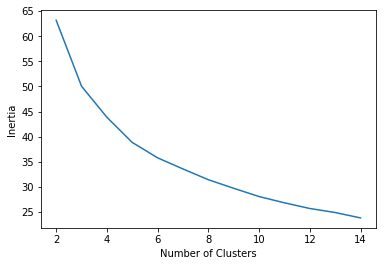

In [6]:
get_elbow_cluster_chart(recent)

### We choose nclusters=5 because that seems like it is the optimal number of clusters from the elbow method.

In [7]:
shot_chart_raw, before_umap_shot_chart_data = get_post_processed_data(recent)

In [ ]:
#if you want to run the kmeans clustering algorithm, generate then save
kmeans = get_model(before_umap_shot_chart_data, n_clusters=5)
pickle.dump(kmeans, open("clusteringshotcharts.pkl", "wb"))

In [21]:
#if you want to use the pre-saved clustering algorithm
kmeans = pickle.load(open("clusteringshotcharts.pkl", "rb"))
predictions = kmeans.predict(before_umap_shot_chart_data)

### We can generate some useful plots with the get_plots function we have implemented

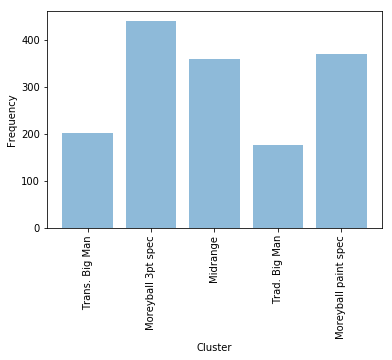

0


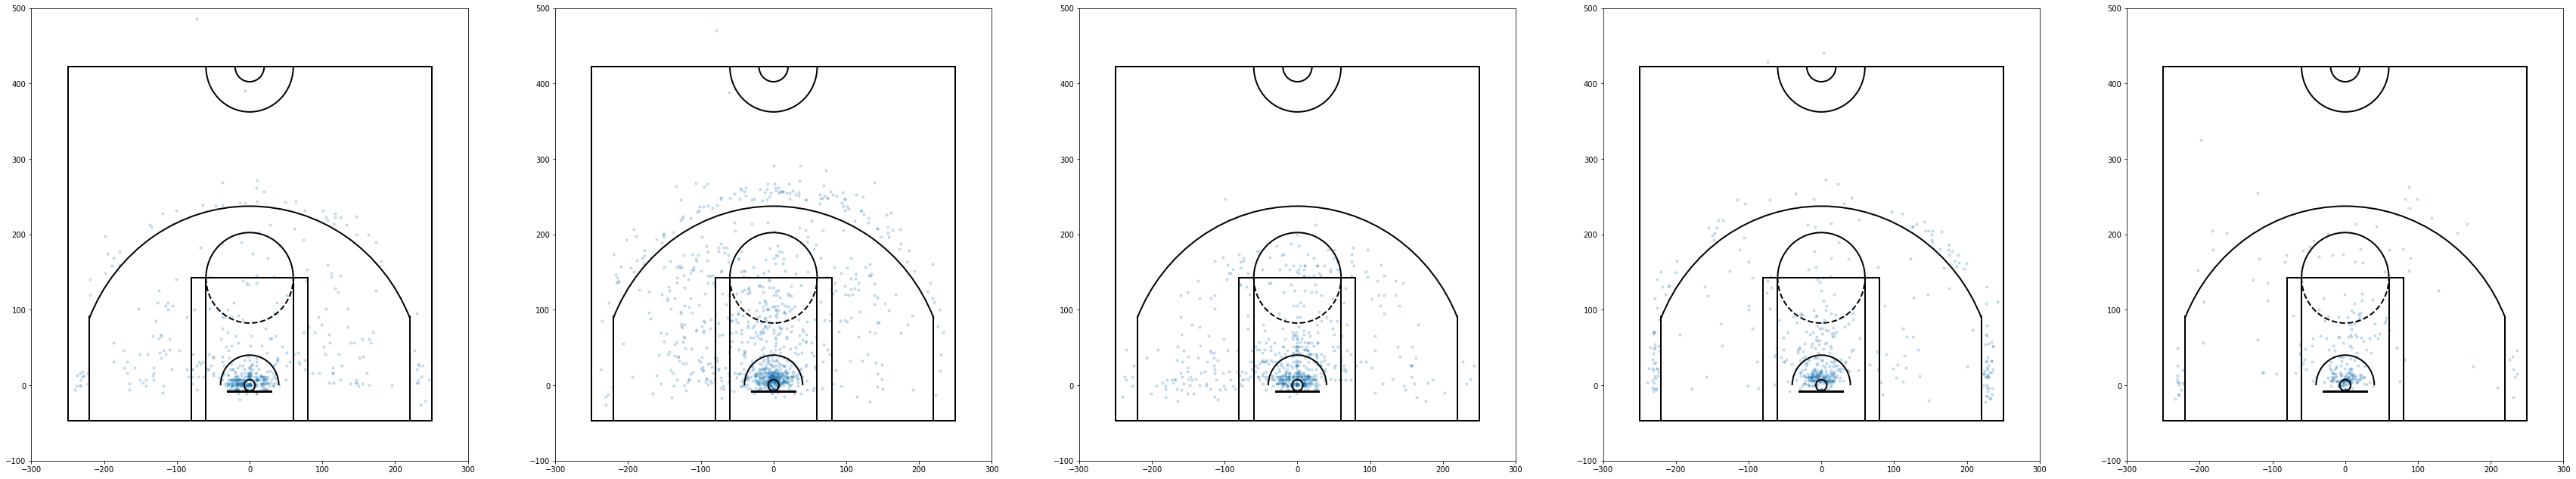

1


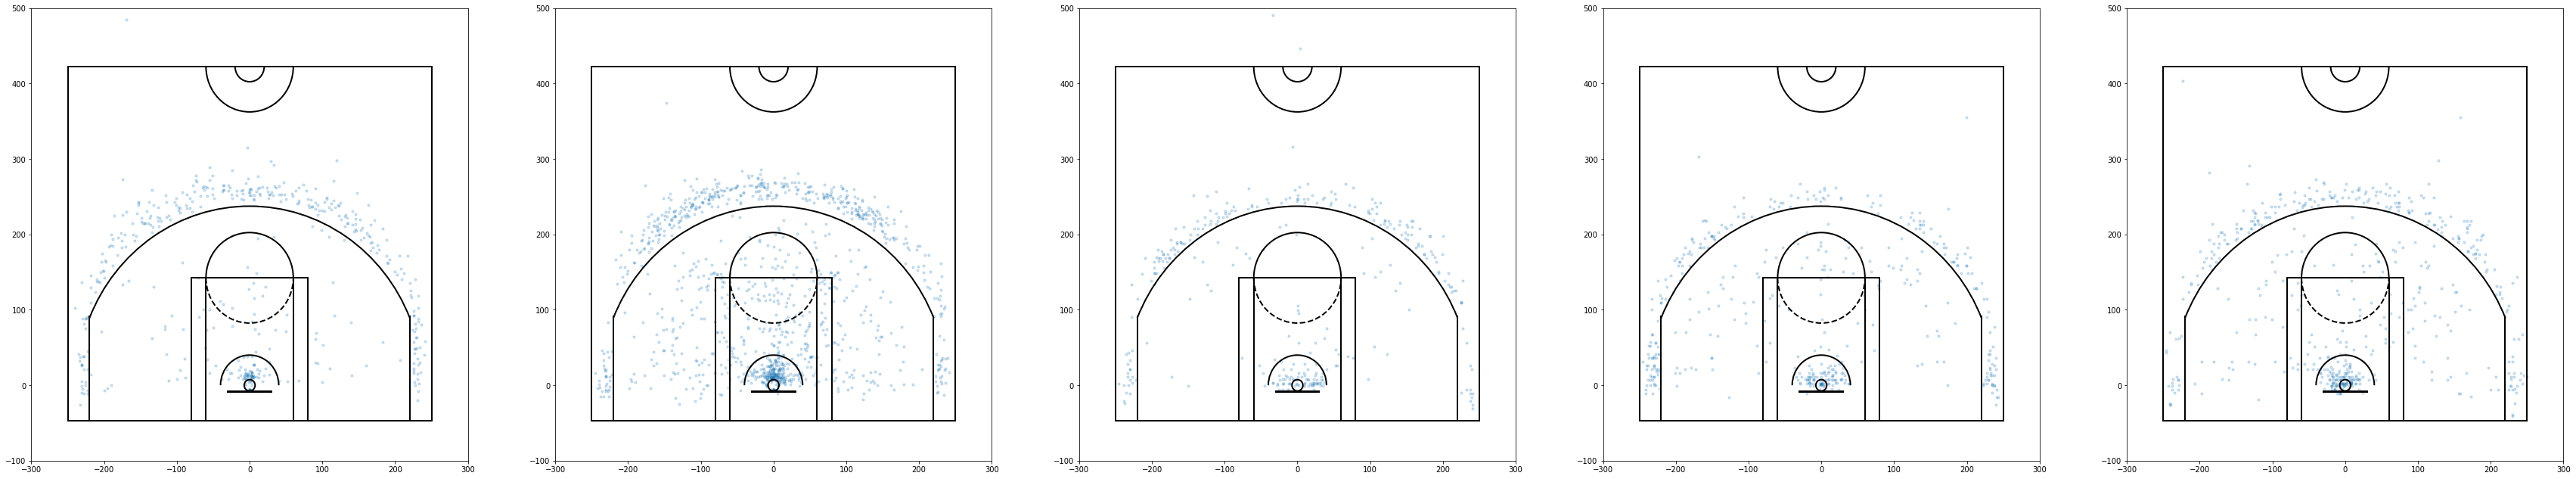

2


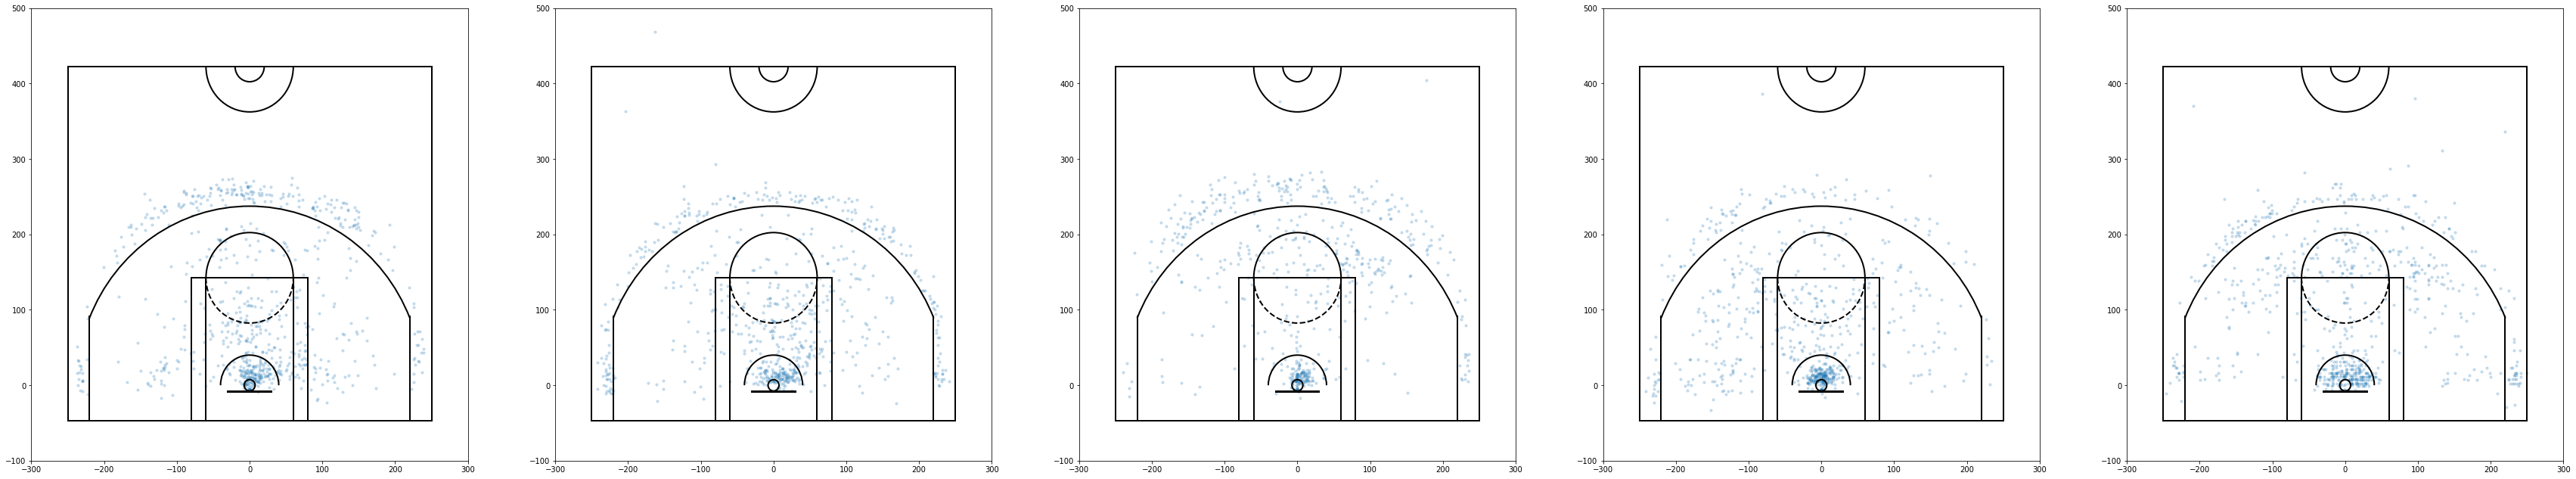

3


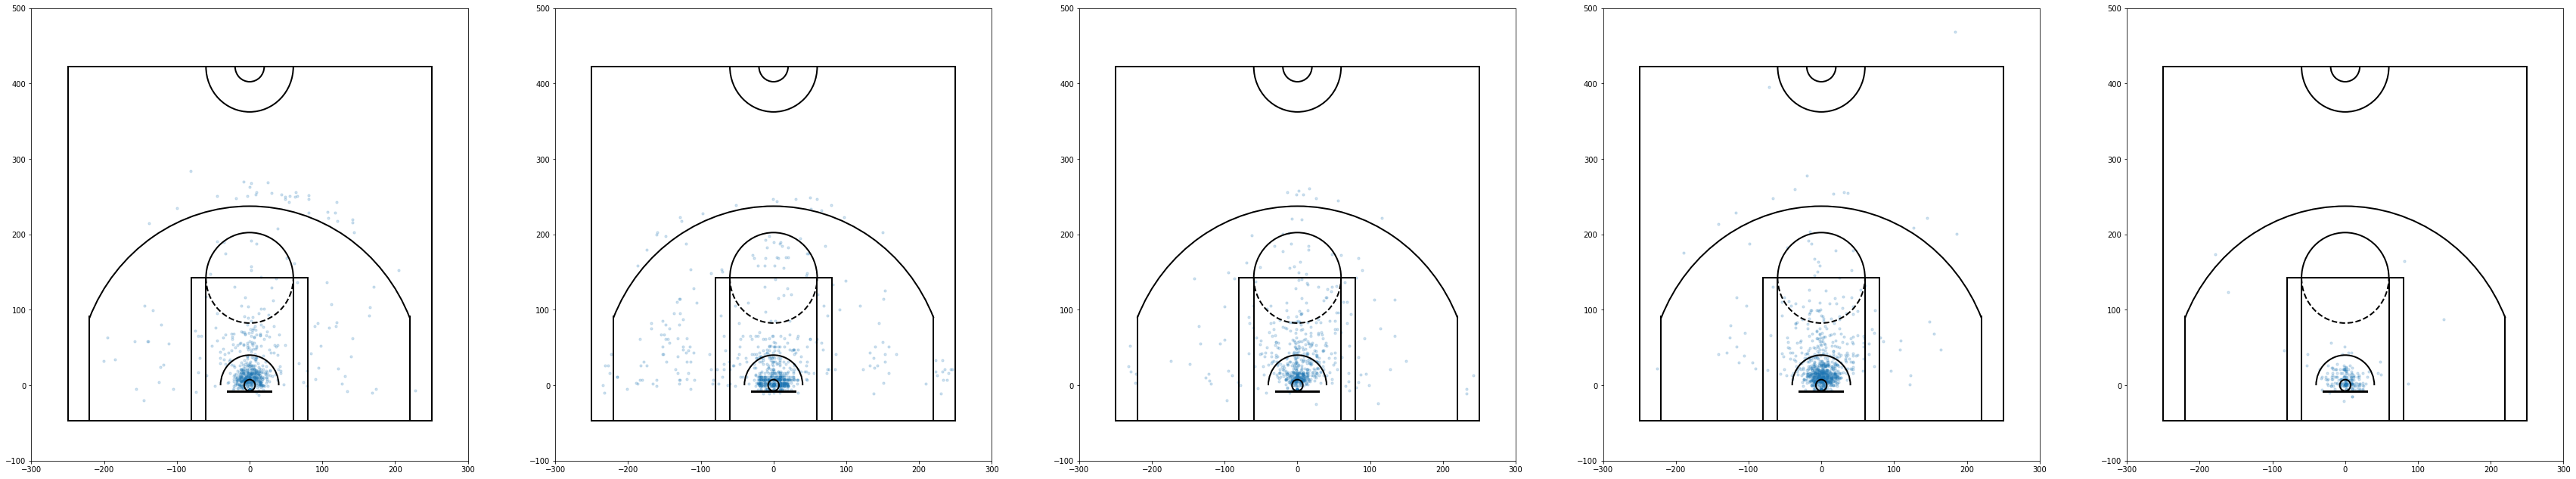

4


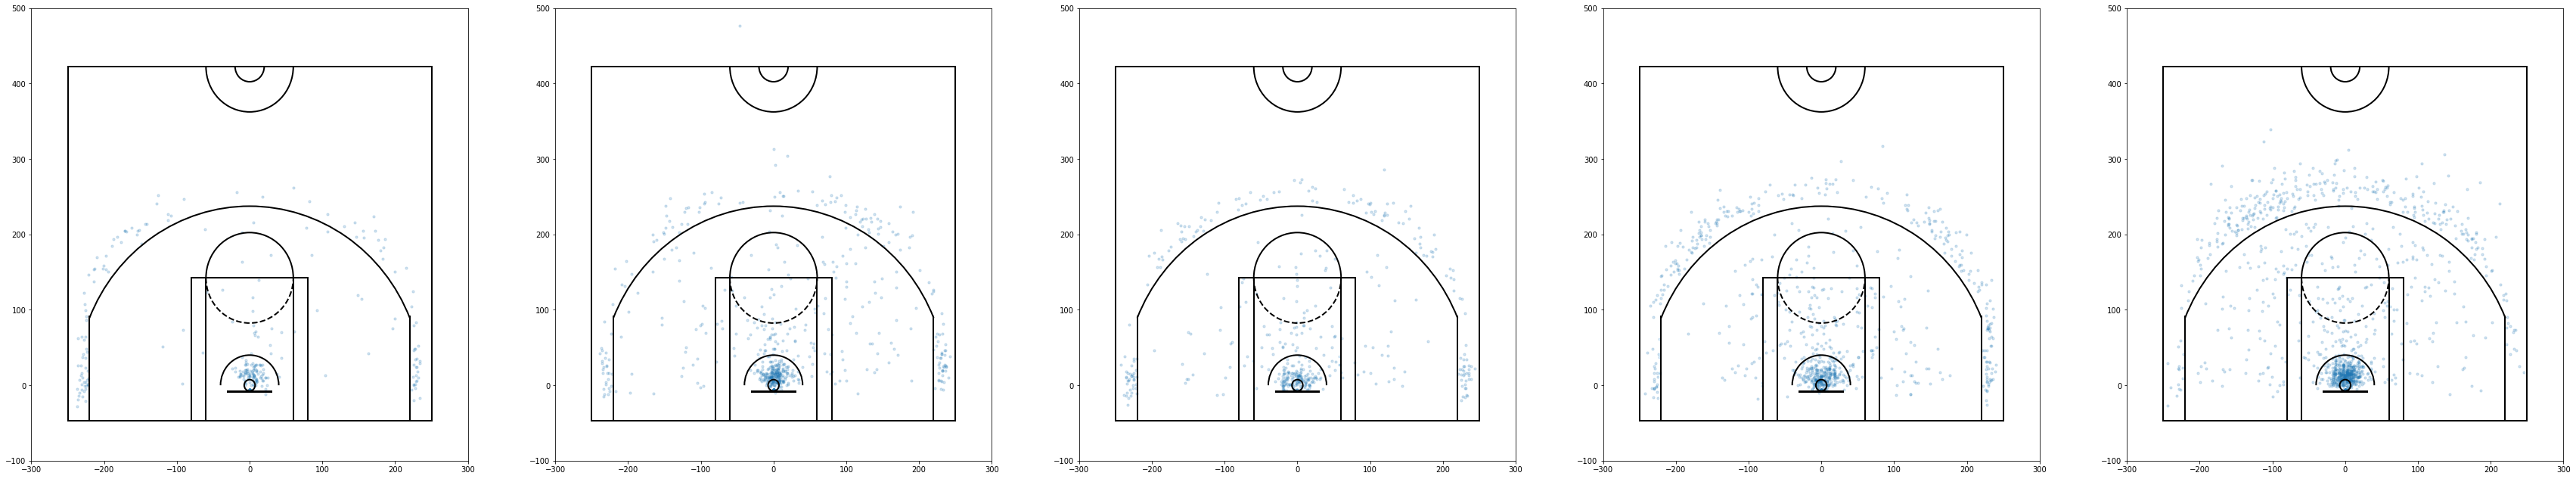

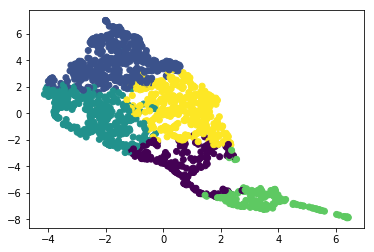

In [9]:
get_plots(kmeans, predictions, shot_chart_raw, before_umap_shot_chart_data, n_clusters=5)

### We generate the distribution for players on certain teams. 

In [10]:
def get_distribution_for_team(model, team, years_cleaned):
    raw_for_this, before_umap_for_this = get_post_processed_data(years_cleaned)
    predictions_for_this = model.predict(before_umap_for_this)
    player_to_prediction = dict(zip(list(raw_for_this.keys()), predictions_for_this))
    number_per_cluster = [0,0,0,0,0]
    for season in list(player_to_prediction.keys()):
        advanced = get_stats_from_scid('advanced', season)
        base = get_stats_from_scid('base', season)
        if base['TEAM_ABBREVIATION'] == team:
            number_per_cluster[player_to_prediction[season]] += 1
    who = [str(thing) for thing in cluster_names]
    plt.bar(who, number_per_cluster, align='center', alpha=0.5)
    plt.ylim([0,35])
    plt.title(team+' Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

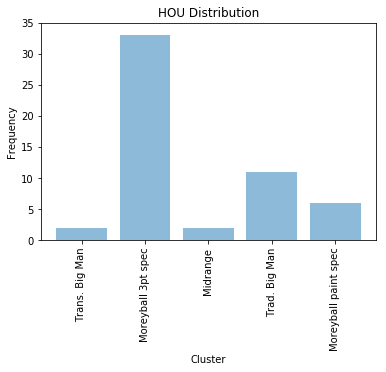

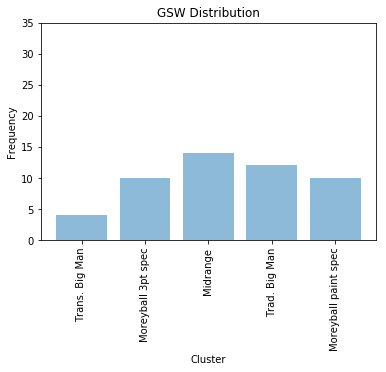

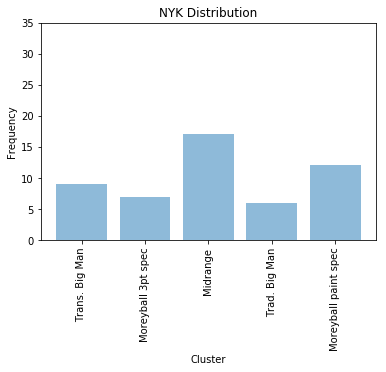

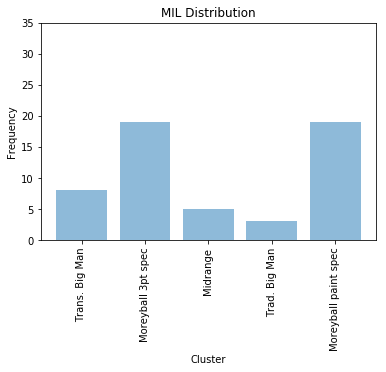

In [11]:
get_distribution_for_team(kmeans, 'HOU', recent)
get_distribution_for_team(kmeans, 'GSW', recent)
get_distribution_for_team(kmeans, 'NYK', recent)
get_distribution_for_team(kmeans, 'MIL', recent)

## For previous years, we generate the distribution using the currently defined clusters

In [12]:
def get_plots_using_new_clusters(model, years):
    raw_for_this, before_umap_for_this = get_post_processed_data(years)
    predictions = model.predict(before_umap_for_this)
    get_plots(model, predictions, raw_for_this, before_umap_for_this, nshotcharts=5)

### We first generate the plots from years 2008-09 through 2010-11

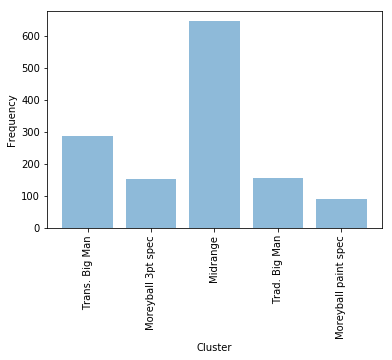

0


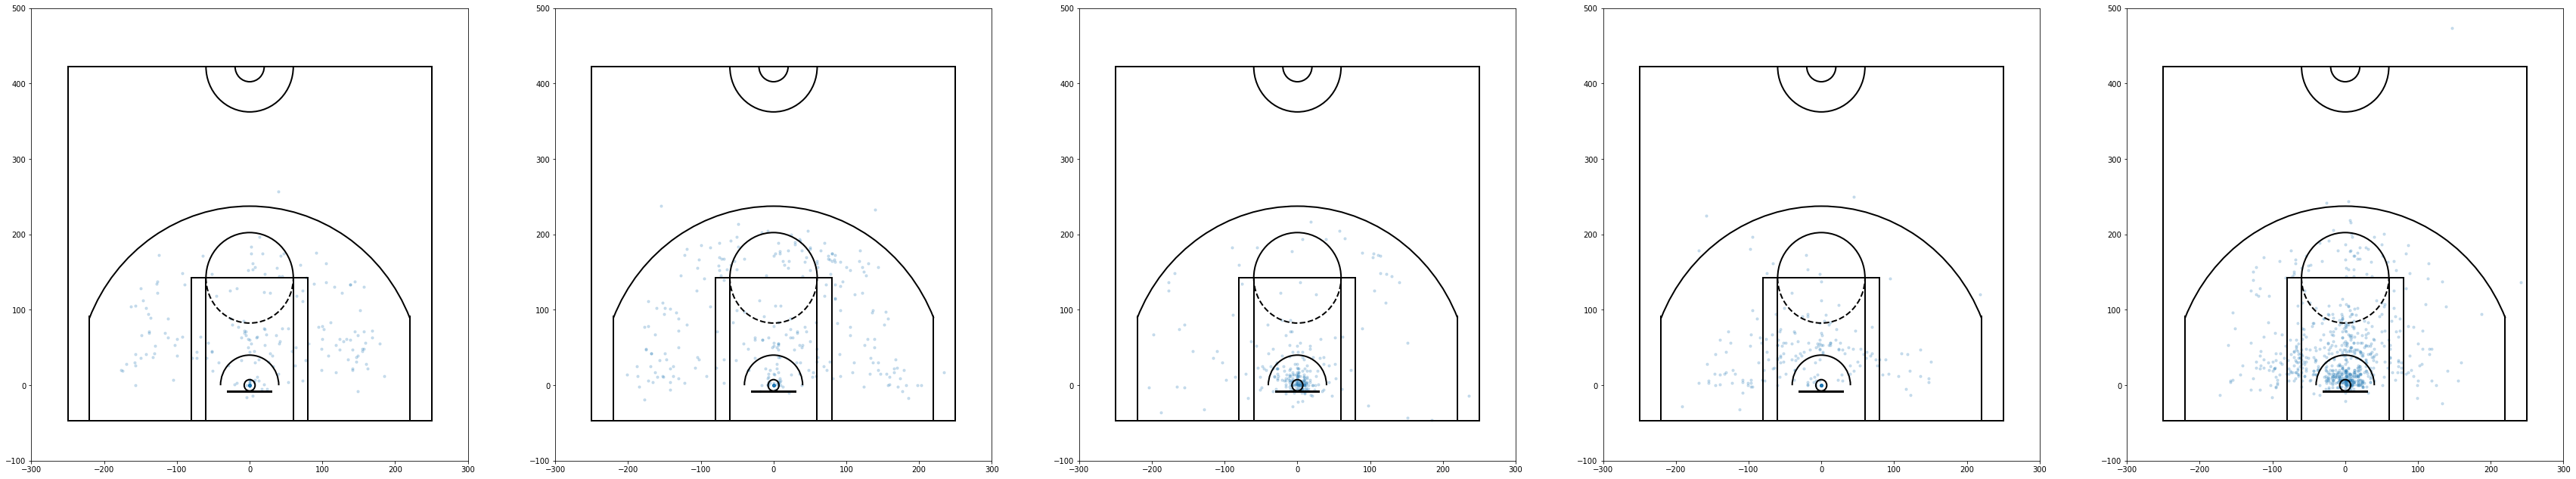

1


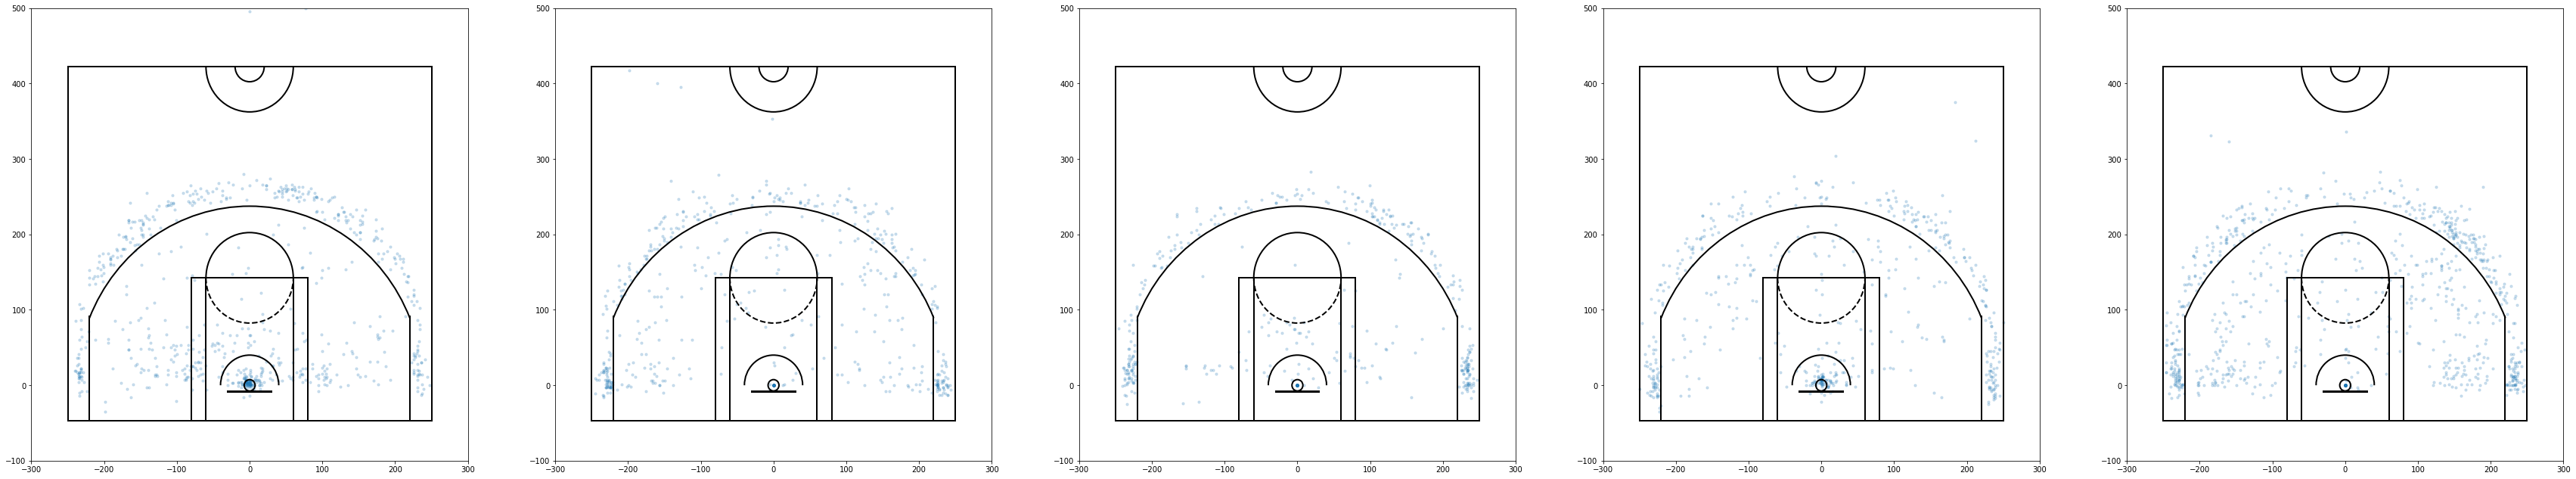

2


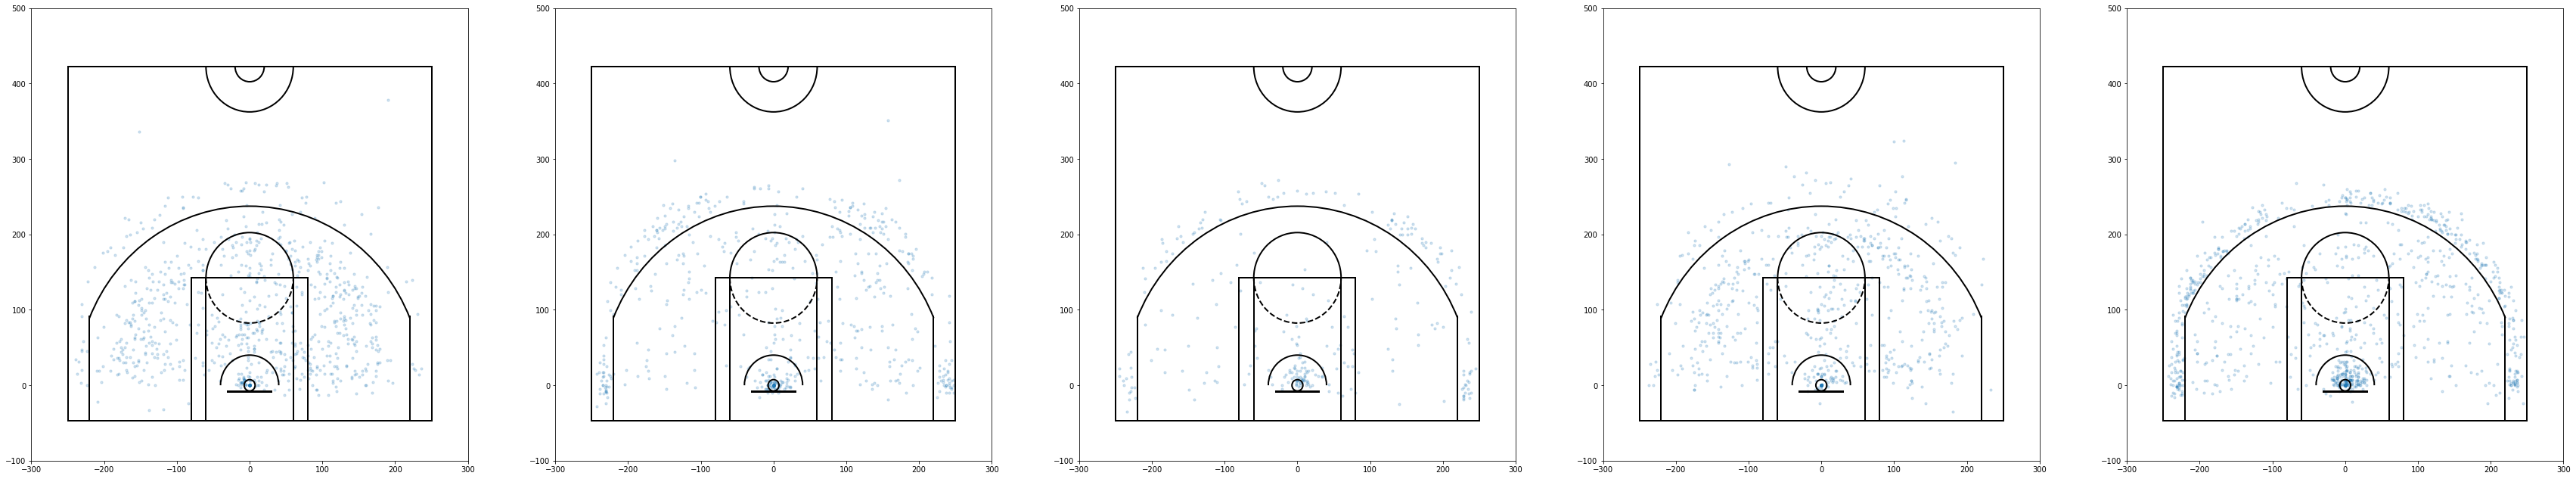

3


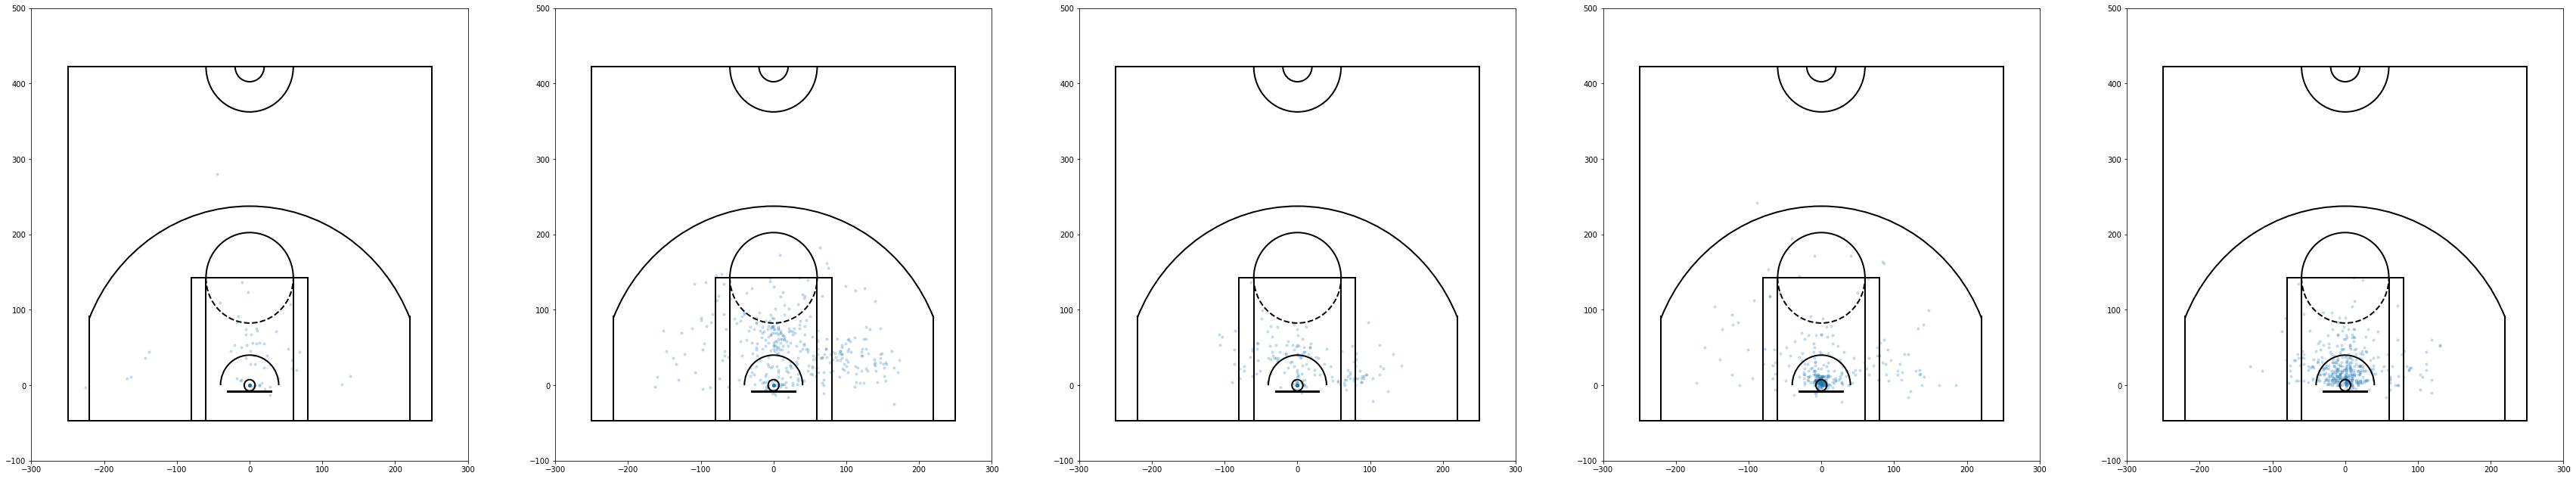

4


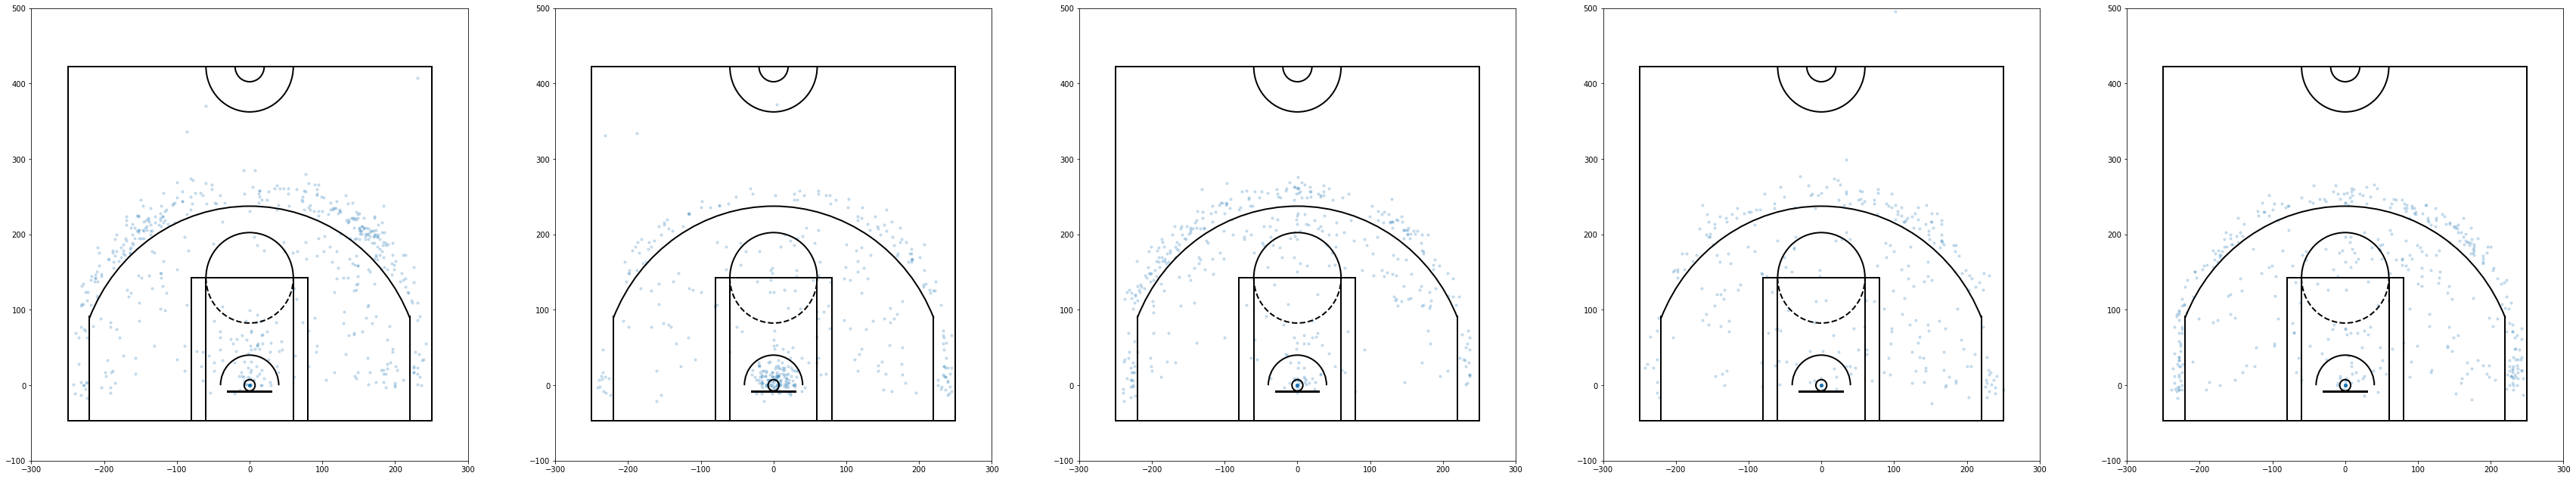

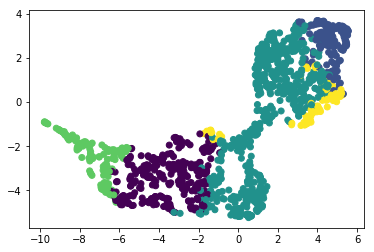

In [13]:
get_plots_using_new_clusters(kmeans, mid)

### We then generate the plots from years 1999-00 through 2001-02

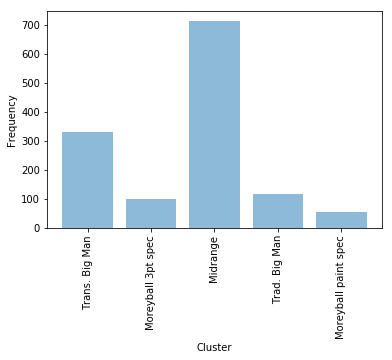

0


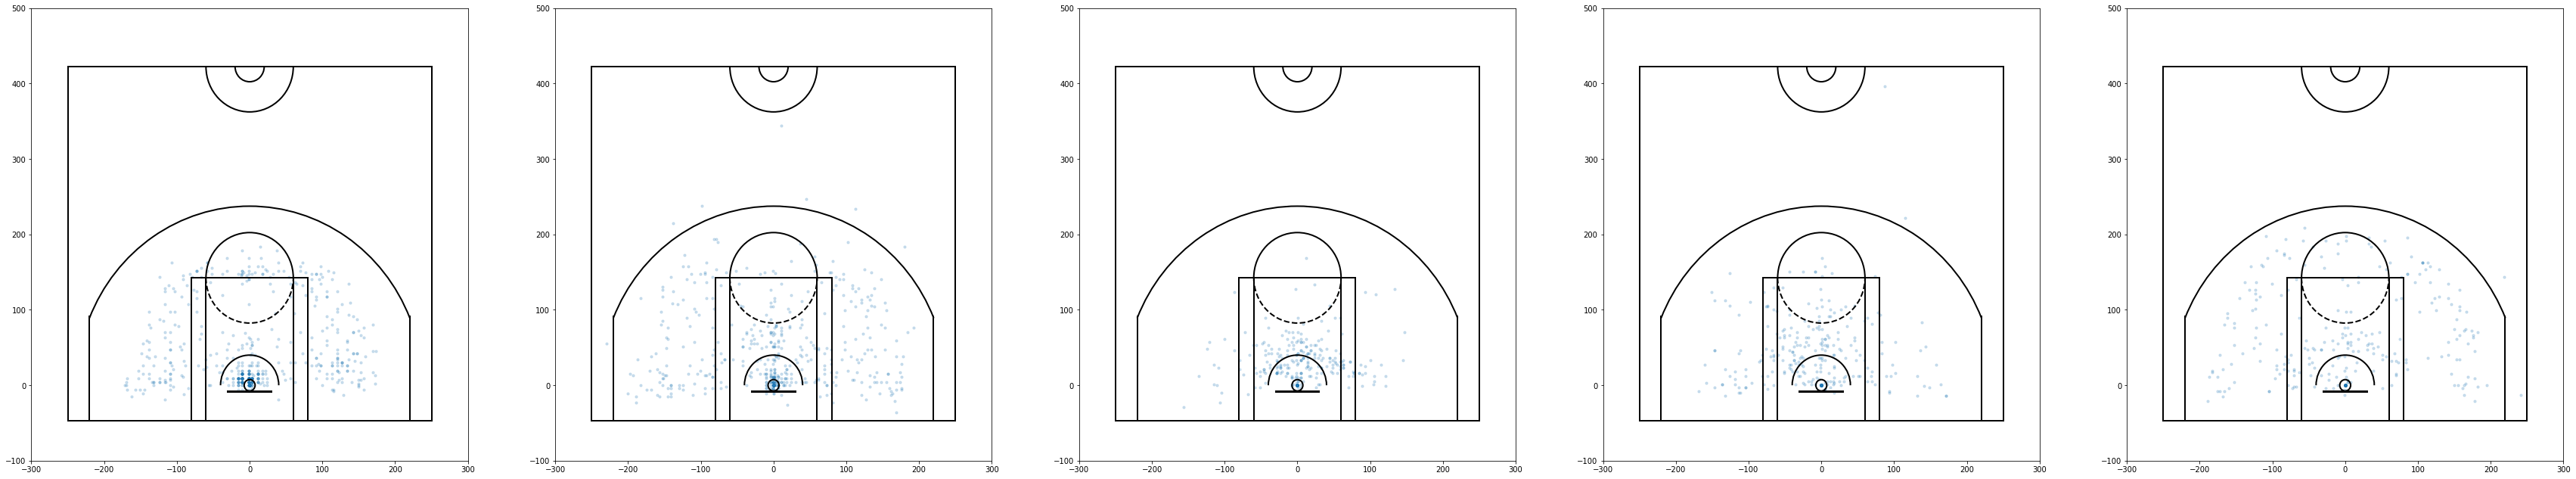

1


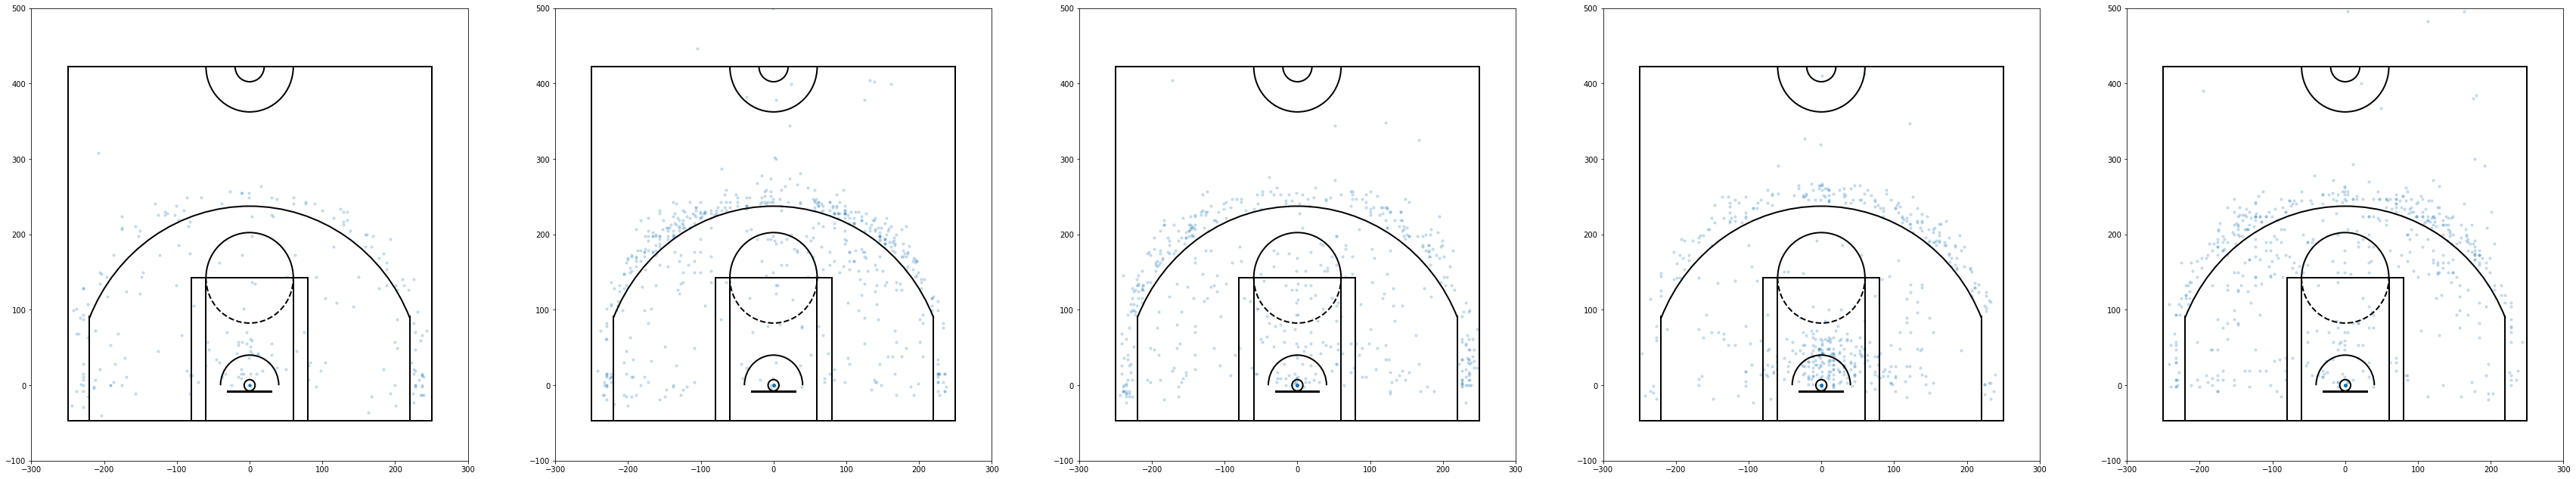

2


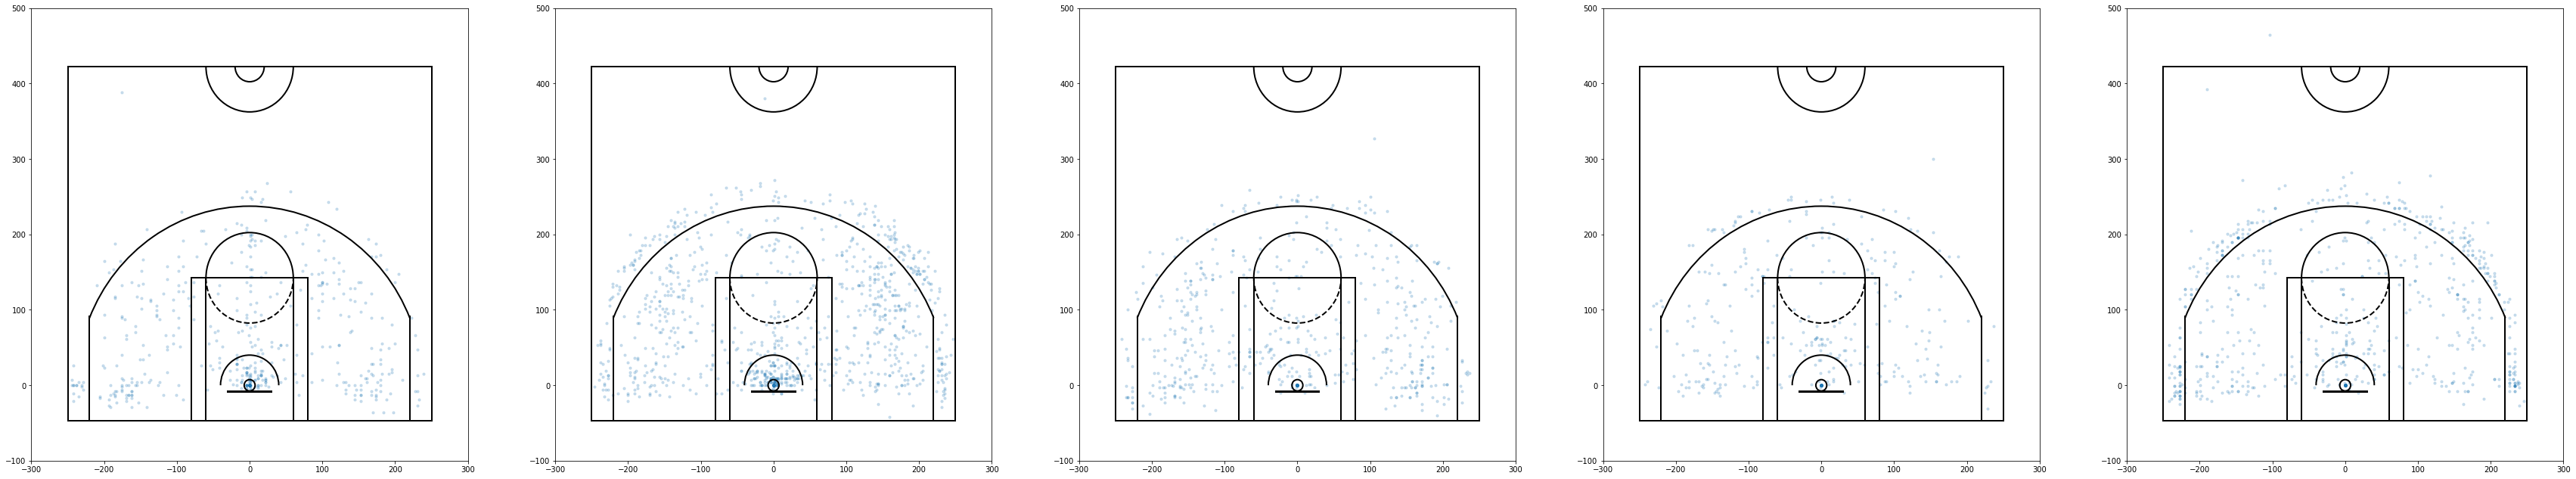

3


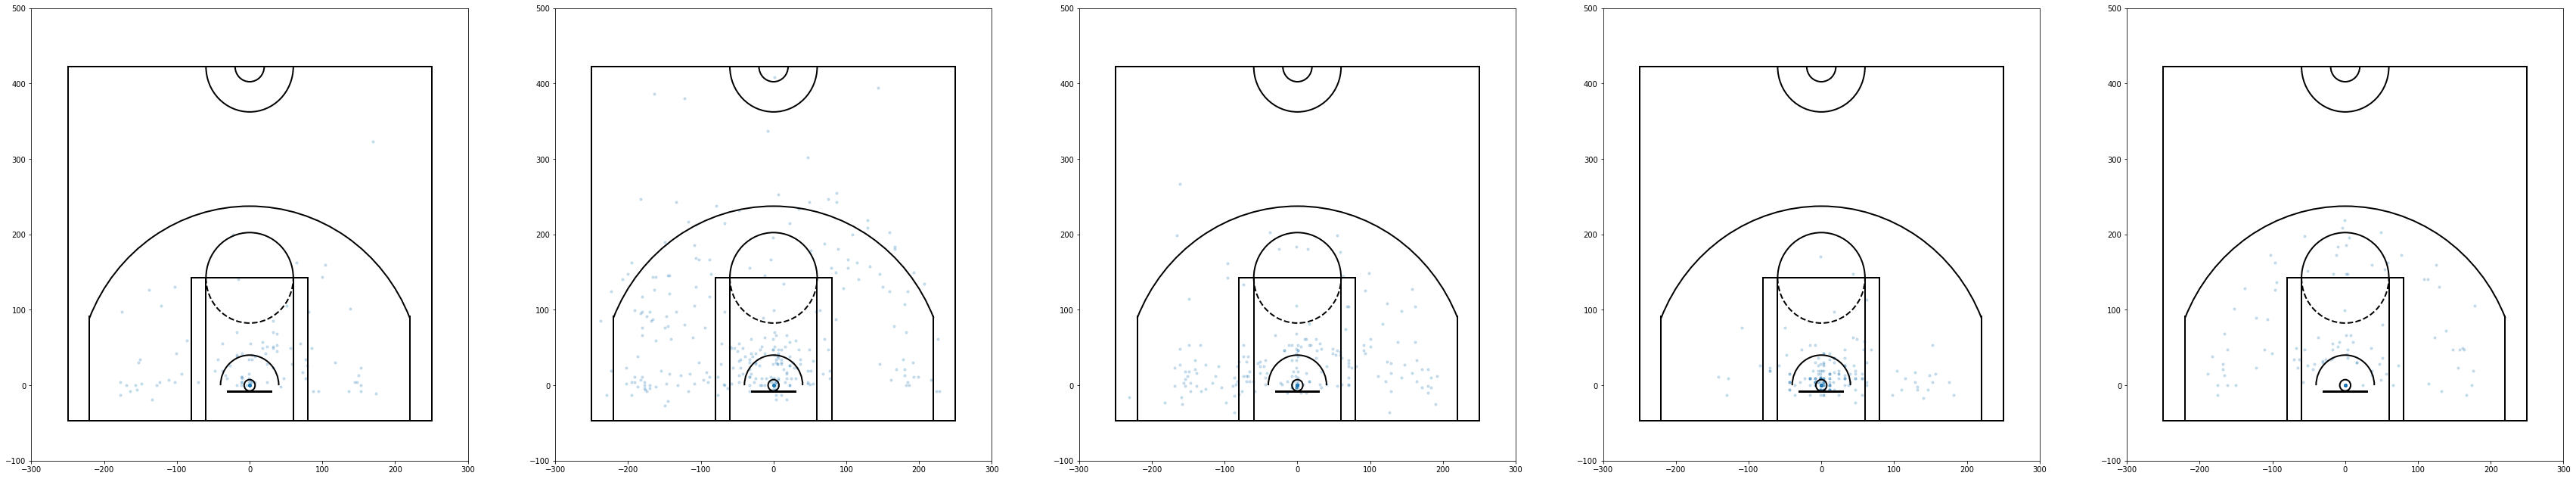

4


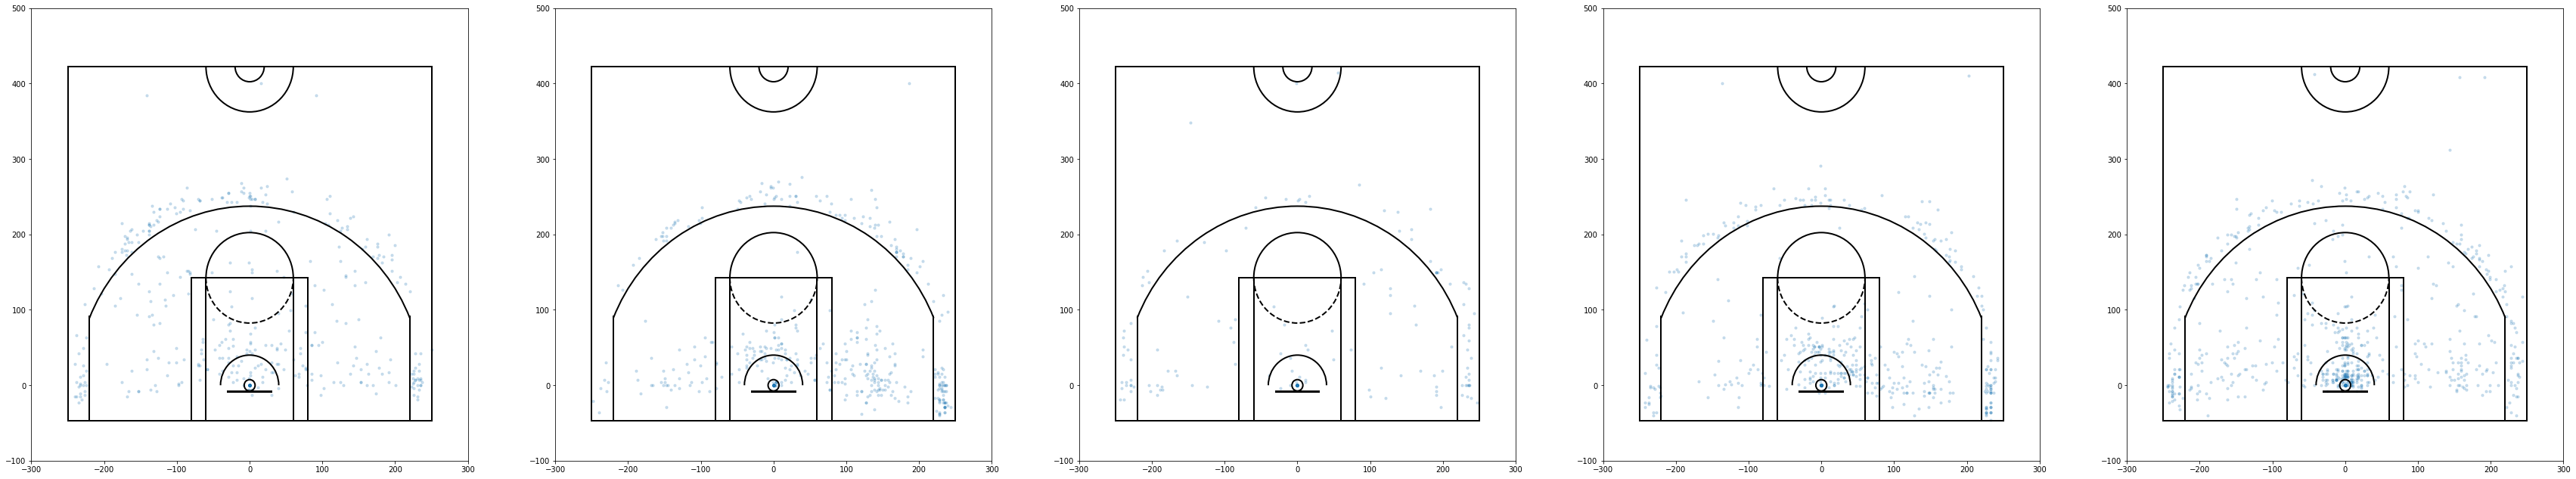

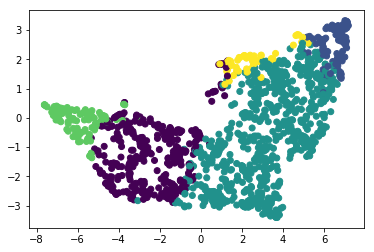

In [14]:
get_plots_using_new_clusters(kmeans, old)

### It is also useful to cross reference statistics, such as EFG_PCT to see which clusters are the most efficient, etc.

In [15]:
def cross_reference_stat(model, typeof, stat, years_cleaned, title):
    raw_for_this, before_umap_for_this = get_post_processed_data(years_cleaned)
    predictions_for_this = model.predict(before_umap_for_this)
    player_to_prediction = dict(zip(list(raw_for_this.keys()), predictions_for_this))
    number_per_cluster = [[],[],[],[],[]]
    for season in list(player_to_prediction.keys()):
        base = get_stats_from_scid(typeof, season)
        mins = base[stat]
        number_per_cluster[player_to_prediction[season]].append(mins)
    averages_per_cluster = []
    for arr in (number_per_cluster):
        averages_per_cluster.append(np.mean(np.array(arr)))
    x = [str(thing) for thing in range(0,5)]    
    plt.bar(x, averages_per_cluster, align='center', alpha=0.5)
    plt.title('Cluster vs '+stat+' '+title)
    plt.ylim([0, 0.7])
    plt.show()

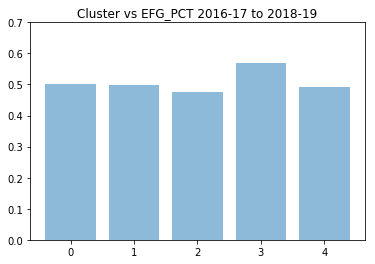

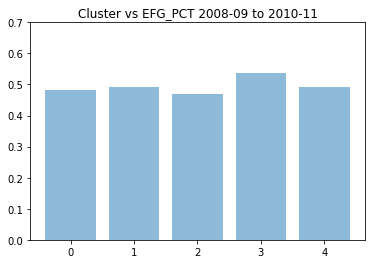

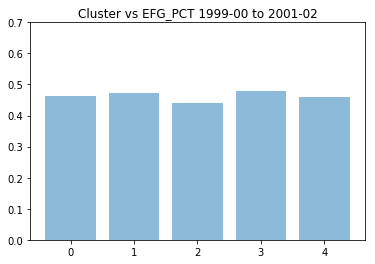

In [16]:
"""
Cluster 0 - Transitioning Big Men
Cluster 1 - Moreyball 3 Point Specialists
Cluster 2 - Midrange Players
Cluster 3 - Traditional Big Men
Cluster 4 - Moreyball Paint Specialist
"""
cross_reference_stat(kmeans, 'advanced','EFG_PCT', recent, "2016-17 to 2018-19")
cross_reference_stat(kmeans, 'advanced','EFG_PCT', mid, "2008-09 to 2010-11")
cross_reference_stat(kmeans, 'advanced','EFG_PCT', old, "1999-00 to 2001-02")

### To get players from each cluster, we can run this method.

In [17]:
def get_players_from_each_cluster(model, years_cleaned):
    raw_for_this, before_umap_for_this = get_post_processed_data(years_cleaned)
    predictions_for_this = model.predict(before_umap_for_this)
    player_to_prediction = dict(zip(list(raw_for_this.keys()), predictions_for_this))
    players_per_cluster = [[],[],[],[],[]]
    for season in list(player_to_prediction.keys()):
        base = get_stats_from_scid('base', season)
        name = base['PLAYER_NAME']
        players_per_cluster[player_to_prediction[season]].append(name)
    return players_per_cluster

In [18]:
clusters = get_players_from_each_cluster(kmeans, recent)

In [19]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [ ]:
for name, cluster in zip(cluster_names, clusters):
    printmd("**"+name+"**")
    for player in cluster:
        printmd(player)
    print('\n\n')